<b> Functions <b>

In [1]:
from qutip import *
import pylab as py
import numpy as np
import matplotlib.pyplot as plt



def heaviside(x):
    if x >= 0 :
        return 1
    if x < 0 :
        return 0
    
def nega(rho, subsys):
    
    #create mask which counts the number of possible subsystems
    x = [0 for i in rho.dims[0]]
   
    #assigns a 1 in the position of the subsystem for which we want to compute the negativity
    x[subsys] = 1
        
    #takes partial transpose with respect to subsys x
    rho_pt = partial_transpose(rho, x)
    
    #finds eivenvalues of pt matrix
    eig = rho_pt.eigenenergies()
    
    #finds abs value of the eigenvalues
    abs_eig = abs(eig)
    
    negat = 0 #initialize value of negativity
    
    #takes the difference 
    diff = (abs_eig - eig)
    
    
    #computes negativity
    for el in diff:
        negat += el

    
    return negat


def three_pi(rho):
    
    #determine pi_a
    N_a_b = nega(rho.ptrace([1,2]),0)
    
    N_a_c = nega(rho.ptrace([1,3]),0)
    
    N_a_bc = nega(rho.ptrace([1,2,3]), 0)
    
    pi_a = max(0,(N_a_bc)**2 - (N_a_b)**2 - (N_a_c)**2)
    
    
    #determine pi_b
    N_b_a = nega(rho.ptrace([1,2]),1)
    
    N_b_c = nega(rho.ptrace([1,3]),0)
    
    N_b_ac = nega(rho.ptrace([1,2,3]), 1)
    
    pi_b = max(0,(N_b_ac)**2 - (N_b_a)**2 - (N_b_c)**2)
    
    #determine pi_c
    N_c_a = nega(rho.ptrace([1,3]),1)
    
    N_c_b = nega(rho.ptrace([2,3]),0)
    
    N_c_ab = nega(rho.ptrace([1,2,3]), 2)
    
    pi_c = max(0,(N_c_ab)**2 - (N_c_a)**2 - (N_c_b)**2)
    
    return (pi_a + pi_b + pi_c)/3

<b> Parameters <b>

In [2]:
# wc = 1   #frequency of cavity photons
# wa = 1  #frequency of qubits


# N = 3      # number of cavity fock states (N-1 photons inn the cavity)
# n_th_a = 0.0           # temperature in frequency units
# g = 0.05*wc # coupling strength

# #time settings
# ti = 0
# tf = 10000
# steps = 20000
# t_list = np.linspace(ti,tf,steps) # vector of time steps

# #dissipation parameters
# kappa = 0.0      # cavity dissipation rate
# gamma1 = 0.01*kappa     # atom 1 dissipation rate
# gamma2 = 0.01*kappa    # atom 2 dissipation rate
# gamma3 = 0.01*kappa     # atom 3 dissipation rate



wc = 10**(9)*2*np.pi*4.343 # frequency of the cavity photons
wa = 10**(9)*2*np.pi*5.439  # transition frequency of the qubits


N = 2      # number of cavity fock states (N-1 photons inn the cavity)
n_th_a = 0.0           # temperature in frequency units
g = 10**(6)*2*np.pi*300 # coupling strength

kappa = 2*np.pi*1.6*10**(6)      # cavity dissipation rate
gamma1 = 2*np.pi*7.6*10**(3)    # atom 1 dissipation rate
gamma2 = 2*np.pi*7.6*10**(3)     # atom 2 dissipation rate
gamma3 = 2*np.pi*7.6*10**(3)     # atom 3 dissipation rate


#time settings
ti = 0 #initial time
tf = 10**(-9)*40 #final time
steps = 2001 #number of steps
t_list = np.linspace(ti,tf,steps) # vector of time steps





<b> Numerical solution <b>

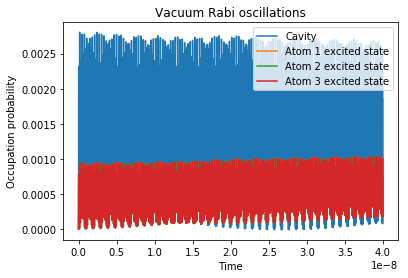

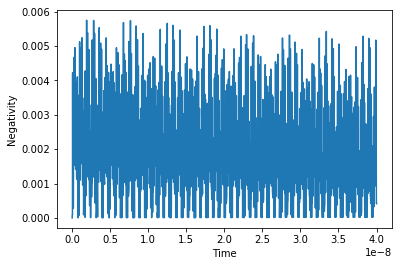

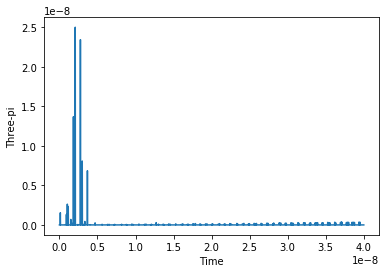

In [3]:


# intial state
psi0 = tensor(basis(N,0), basis(2,0), basis(2,0), basis(2,0))    # start with 0 excited atoms and 0 photons


# density matrix
rho0 = ket2dm(psi0)


# operators
a  = tensor(destroy(N), qeye(2), qeye(2), qeye(2)) #destroy cavity photon
sm1 = tensor(qeye(N), destroy(2),qeye(2), qeye(2)) #destroy atom1 excitation
sm2 = tensor(qeye(N), qeye(2),destroy(2), qeye(2)) #destroy atom2 excitation
sm3 = tensor(qeye(N), qeye(2), qeye(2), destroy(2)) #destroy atom3 excitation


#list of collapse operator (dissipation ops) for separate baths (for Lindblad's equation)    
c_op_list = []

rate = kappa #photon dissipation
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * a) 


rate = gamma1 #atom1 dissipation
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * sm1)
    
rate = gamma2 #atom2 dissipation
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * sm2)

rate = gamma3 #atom2 dissipation
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * sm3)


    
    
#Hamiltonian

def H1_coeff(t,args):
    coeff = g*heaviside(np.cos((wa+wa)*t))
    return coeff

H0 = wc*a.dag()*a + wa*sm1.dag()*sm1 + wa*sm2.dag()*sm2 + wa*sm3.dag()*sm3

H1 = (a.dag()*sm1 + a*sm1.dag() + a.dag()*sm2 + a*sm2.dag() + a.dag()*sm3 + a*sm3.dag()  + a*sm1 + a.dag()*sm1.dag() + a*sm2 + a.dag()*sm2.dag() + a*sm3 + a.dag()*sm3.dag() )


H = [H0,[H1,H1_coeff]]




#solve master equation
output = mesolve(H, rho0, t_list, c_op_list, [a.dag() * a, sm1.dag() * sm1, sm2.dag() * sm2 , sm3.dag() * sm3])  #stores expectation values of number of phontons, excitation of atom 1, 2, 3 

result = mesolve(H, rho0, t_list, c_op_list)  #stores density matrix operator changing in time



# plot excitation probabilities of photons and atoms
plt.plot(t_list, output.expect[0], label="Cavity")
plt.plot(t_list, output.expect[1], label="Atom 1 excited state")
plt.plot(t_list, output.expect[2], label="Atom 2 excited state")
plt.plot(t_list, output.expect[3], label="Atom 3 excited state")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.title('Vacuum Rabi oscillations');
plt.show()


neg = np.zeros(steps) #initialize vector of numerical time evolved negativity

res_pi = np.zeros(steps) #initialize vector of numerical time evolved three-pi


#computes the time evolution of the negativity
for i in range(steps):

    neg[i] = nega(result.states[i].ptrace([1,2,3]), 1) #find negativity
    
    res_pi[i] = three_pi(result.states[i]) #find three-pi

    
    
#plot numerical negativity
plt.plot(t_list, neg)
plt.xlabel('Time')
plt.ylabel('Negativity')
plt.show()

#plot numerical three-pi
plt.plot(t_list, res_pi)
plt.xlabel('Time')
plt.ylabel('Three-pi')
plt.show()



